<hr style="border-width:4px;border-color:coral" />

# Parallel algorithm for solving the 2d Poisson problem

<hr style="border-width:4px;border-color:coral" />

This notebook gives you an introduction to solving the 2d heat equation using the finite difference approach.  

* <a href="#poisson">2d Poisson problem</a>

* <a href="#plotsolution">Plot the solution</a>

<a id="poisson"></a>

<hr style="border-width:4px; border-color:coral"></hr>

The 2d elliptic equation is given by

\begin{equation*}
\nabla^2 q = f
\end{equation*}

where $q(x,y,t)$ is a function of two spatial variables $\mathbf x = (x,y)$ and $\nabla^2 q$ is the 2d Laplacian given by 

\begin{equation*}
\nabla^2 q \equiv q_{xx} + q_{yy}.
\end{equation*}

We solve this problem in the domain $[0,1]\times [0,1]$.  For this problem, we apply Dirichlet boundary conditions.

The general mesh consisting of points $(x_i,y_j)$ is given by 

\begin{equation*}
\begin{aligned}
x_i & = i\Delta x, \qquad i = 0,1,2, ..., N_x \\
y_j & = j\Delta y, \qquad j = 0,1,2, ..., N_y
\end{aligned}
\end{equation*}

where $\Delta x = 1/N_x$ and $\Delta y = 1/N_y$. 

Our semi-discrete system in 2d is given by

\begin{equation}
\frac{Q_{i-1,j}(t) - 2 Q_{ij}(t) + Q_{i+1,j}(t)}{(\Delta x)^2} + 
\frac{Q_{i,j-1}(t) - 2 Q_{ij}(t) + Q_{i,j+1}(t)}{(\Delta y)^2} = f(x_i,y_j)
\end{equation}

## Parallel strategies

We can solve the Poisson problem in parallel on node-centered mesh in one of two ways. 

1. **Duplicated nodes**. Nodes at parallel boundaries are duplicated on each processor adjacent to the common shared parallel boundary
2. **No duplicated nodes**. Nodes at parallel boundaries are owned by exactly one processor. 

The first approach has the advantage that all processors treat interior nodes equally and so there is no confusion about who "owns" a node at the parallel boundary.  The disadvantage is that the linear system defined by the matrix vector multiply is no longer symmetric.  This loss of symmetry may impact the convergence behavior of the conjugate gradient algorithm.  

The second approach requires more logic at the parallel boundaries, since now, each node is owned by exactly one processor.   However, the linear system that is implicitly defined by the matrix-vector multiply is now symmetric, and so convergence will be the same as for the serial case. 

In the codes used for this problem, the two versions above are implemented in files `comm_duplidate.c` and `comm_no_duplicate.c`.  

In [4]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


<a id="loaddata"></a>
<hr style="border-color:coral; border-width:4px"></hr>


## Problem 1, (Homework #4, Problem 3)

<hr style="border-color:coral; border-width:4px"></hr>

The equation for the homework problem is given by

\begin{equation*}
\nabla^2 u =  -8 \pi^2 \sin(2\pi x)\sin(2\pi y)
\end{equation*}

You can try the homework problem below.  

In [20]:
%%bash

rm -rf solve_Poisson iterative.out

# Build with duplicated nodes (discussed in class)
make comm_dup

# Build with no duplicate nodes  (matrix is symmetric)
# make comm_nodup

echo " "

# Args : <dimx> <dimy> <N> <tol> <kmax> <prt>

time mpirun -n 2 solve_Poisson 2 1 256 1e-12 10000 1

mpicc -o solve_Poisson -O0 -g solve_Poisson2d_parallel.c cg_parallel.c bicg_parallel.c splitting2d_parallel.c mpi_debug.c comm_duplicate.o -lm
 

Input arguments
         Dim[0]          2
         Dim[1]          1
              N        256
            tol      1e-12
           kmax      10000
            prt          1

Optional arguments
        Problem          1   (1=utrue1; 2=utrue2)
         Method          2   (CG=2; BiCG=3)
          debug          0


Iterations
       0   1.00005020e+00
       1   1.45233031e-13

Results
       256          2   1.45233031e-13   2.0344e-05   2.5100e-05   5.0201e-05



real	0m0.026s
user	0m0.031s
sys	0m0.011s


<a id="loaddata"></a>
<hr style="border-color:coral; border-width:4px"></hr>

## Problem 2

<hr style="border-color:coral; border-width:4px"></hr>

The homework problem converged with surprisingly few iterations.  This may be due to the fact that the right side function is an eigensolution to the PDE.  Using  a different right hand, we see convergence behavior that is much more typical of iterative methods.  Also, we will see that duplicated node approach still converges, but no optimally. 

For this problem, we use the "method of manufactured solution" and compute a right hand side from a given known solution.  We specify the true solution as

\begin{equation}
u(x,y) = f(x,y)g(x,y)
\end{equation}

where

\begin{eqnarray}
f(x,y) & = e^{-a (x^2 + y^2)} \\
g(x,y) & = \sin(2\pi x)\sin(2\pi y)
\end{eqnarray}

Rather than deriving the Laplacian analytically, we compute the Laplacian in the code by computing first and second derivatives of the functions $f(x,y)$ and $g(x,y)$, and compute

\begin{eqnarray}
\nabla^2 u & = g\nabla^2 f + 2 (\nabla f) \cdot (\nabla g) + f \nabla^2 g
\end{eqnarray}

Run the code below to see that the both the duplicated code and the non-duplicated code converge, but only the non-duplicated code converges with the same number of iterations as the serial code. 

In [17]:
# Define some parameters
prob = 1

In [18]:
%%bash

rm -rf solve_Poisson iterative.out

# Build with duplicate nodes
# make comm_dup

# Build with no duplicated nodes
make comm_nodup

echo " "

# Args : <dimx> <dimy> <N> <tol> <kmax> <prt> <prob>

time mpirun -n 2 solve_Poisson 1 2 256 1e-12 10000 0 1

mpicc -o solve_Poisson -O0 -g solve_Poisson2d_parallel.c cg_parallel.c bicg_parallel.c splitting2d_parallel.c mpi_debug.c comm_no_duplicate.o -lm
 

Input arguments
         Dim[0]          1
         Dim[1]          2
              N        256
            tol      1e-12
           kmax      10000
            prt          0

Optional arguments
        Problem          1   (1=utrue1; 2=utrue2)
         Method          2   (CG=2; BiCG=3)
          debug          0


Iterations

Results
       256          2   1.45233039e-13   2.0344e-05   2.5100e-05   5.0201e-05



real	0m0.030s
user	0m0.036s
sys	0m0.015s


<hr style="border-width:4px; border-color:coral"></hr>

## Read meta data
<hr style="border-width:4px; border-color:coral"></hr>

Meta data is stored by the executable and read in here.  It is a good idea to check that everything that was read in is correct and agrees with what you expect.  

In [12]:
# Open file for reading; use binary mode
fout = open("iterative.out","rb")

# Read meta data
dt_meta = dtype([('ax','d'),('bx','d'),('ay','d'),('by','d'),('Nx','int32'),('Ny','int32')])
d = fromfile(fout,dtype=dt_meta, count=1)[0]

# create dictionary containing meta data
parms = {}
for i,k in enumerate(dt_meta.fields):
    parms[k] = d[k]

# Print meta data from dictionary
print("Mesh cell dimensions : ({Nx:2d},{Ny:2d})".format(**parms))
print("")
print("Domain : [{ax:g},{bx:g}] x [{ay:g},{by:g}]".format(**parms))
print("")

# Assign values in tuple directly (for use below)
ax,bx,ay,by,Nx,Ny = d

# Read solution data and count number of output steps.  This should match number
# set by the user in call to `cg2d`
dt_cg = dtype([('q','d',(Nx+1)*(Ny+1))])  
data = fromfile(fout,dtype=dt_cg)

# Close file
fout.close()

Mesh cell dimensions : (256,256)

Domain : [0,1] x [0,1]



## Create the 2d mesh

We create a 2d mesh needed for plotting. 

In [13]:
xe = linspace(ax,bx,Nx+1)
ye = linspace(ay,by,Ny+1)

dx = (bx-ax)/Nx
dy = (by-ay)/Ny

[xm,ym] = meshgrid(xe,ye)

<a id="plotting"></a>

<hr style="border-width:4px; border-color:coral"></hr>

## Plot the solution

<hr style="border-width:4px; border-color:coral"></hr>

<IPython.core.display.Javascript object>


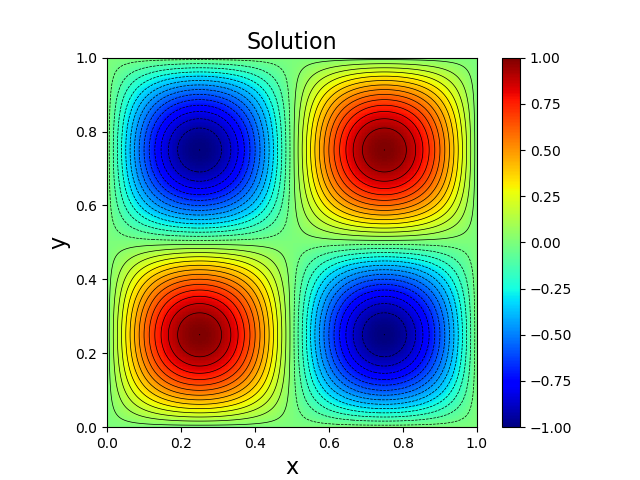

In [19]:
# Plot initial conditions
figure(1)
clf()

set_cmap('jet')

q = reshape(data[0][0],(Nx+1,Ny+1))

# Problem #1
mesh = pcolormesh(xm,ym,q.T,vmin=-1,vmax=1)
cv = linspace(-1,1,30)

# Problem #2
# mesh = pcolormesh(xm,ym,q.T)
# cv = linspace(-0.6,0.34,40)

cont = contour(xm,ym,q.T,colors='k',levels=cv,linewidths=0.5)

gca().set_aspect(1)

title('Solution',fontsize=16)
xlabel('x',fontsize=16)
ylabel('y', fontsize=16)

colorbar(mesh)

show()
